В этом ноутбуке будем работать с моделями из репозитория [pyod](https://github.com/yzhao062/pyod), которые позиционируют себя как "comprehensive and scalable python toolkit for detecting outlying objects in multivariate data". 

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [15]:
! pip install pyod 

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.6/120.6 KB 871.3 kB/s eta 0:00:00 MB/s eta 0:00:01:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 4.0 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 3.3 MB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for pyod: filename=pyod-1.0.1-py3-none-any.whl size=147473 sha256=08ac52e403706f7d0d2e887d743a0cbc7edeb5a565588671103a89b0efe6e34c
  Stored in directory: /home/dabdya/.cache/pip/wheels/b1/cc/4c/627210c240d68c4932857dd69725a40032b429dd967323314a
Successfully built pyod
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### Load dataset

In [43]:
df = pd.read_excel("./data/SWAT.xlsx")
df.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 7:50:00 AM,2.462287,541.3740,2,1,1,260.7344,8.409895,324.8398,0.000513,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
1,28/12/2015 7:50:01 AM,2.441469,541.4918,2,1,1,260.7344,8.412138,324.3015,0.000256,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
2,28/12/2015 7:50:02 AM,2.428338,541.2955,2,1,1,260.7344,8.414701,323.7888,0.000256,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
3,28/12/2015 7:50:03 AM,2.425776,542.5124,2,1,1,260.7344,8.420149,323.3530,0.000256,...,2,1,251.4580,1.441707,190.1436,0.000064,1,1,1,Normal
4,28/12/2015 7:50:04 AM,2.424174,542.7871,2,1,1,260.7344,8.423674,322.8916,0.000256,...,2,1,251.2817,1.441707,190.1436,0.000064,1,1,1,Normal


In [50]:
df['Normal/Attack'].replace({'Normal':0, 'Attack':1})
df["anomaly"] = df["Normal/Attack"]

anomaly = df.anomaly
df.drop(["Normal/Attack"], axis=1, inplace=True)

In [55]:
important_features = [
    'LIT101', 'MV301', 'MV302', ' MV303', 'MV304', 'P302', 'AIT401', 'AIT504', 'FIT504', 'PIT502', 'P602']

In [56]:
df = df[important_features]
df.head()

,LIT101,MV301,MV302,MV303,MV304,P302,AIT401,AIT504,FIT504,PIT502,P602
0,541.3740,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1
1,541.4918,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1
2,541.2955,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1
3,542.5124,1,1,1,1,1,148.808,12.03538,0.306761,1.441707,1
4,542.7871,1,1,1,1,1,148.808,12.03538,0.306761,1.441707,1


In [ ]:
first_anomaly_index = anomaly[anomaly == 1].index[0]
train_size = int(first_anomaly_index * 0.8)

### Make prediction

In [35]:
from pyod.models.auto_encoder import AutoEncoder
from tensorflow.keras.losses import mean_absolute_error as mae

In [36]:
params = {
    "hidden_neurons": [64, 32, 16, 8, 8, 16, 32, 64],
    "epochs": 5,
    "batch_size": 16,
    "loss": mae,
    "random_state": 42,
}

ae = AutoEncoder(**params).fit(df[:train_size])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 11)                132       
                                                                 
 dropout_20 (Dropout)        (None, 11)                0         
                                                                 
 dense_23 (Dense)            (None, 11)                132       
                                                                 
 dropout_21 (Dropout)        (None, 11)                0         
                                                                 
 dense_24 (Dense)            (None, 64)                768       
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)               

In [73]:
r = pd.Series(ae.decision_function(df[train_size:]))
prediction = (r > r.quantile(0.75) + 1.5 * (r.quantile(0.75) - r.quantile(0.25))).values

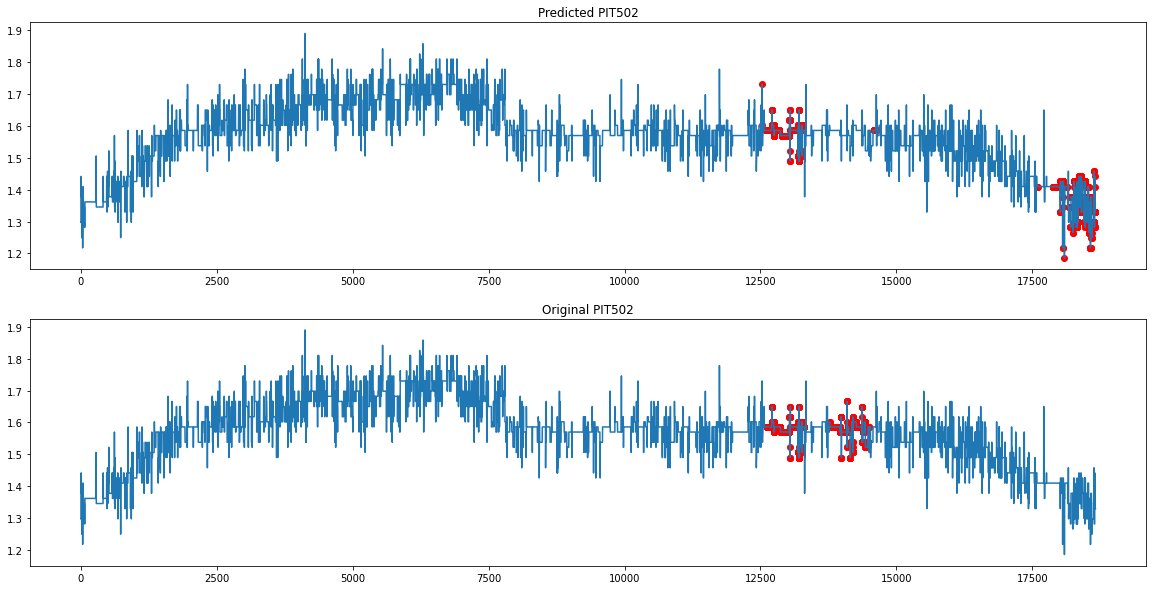

In [78]:
p = "PIT502"

fig, axs = plt.subplots(2, 1, figsize=(20,10))
p_data = df[p]
axs[0].plot(p_data)
axs[1].plot(p_data)

y = pd.Series(prediction, index=df[train_size:].index)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, p_data[anomalies_indecies], color='r')
axs[0].set_title(f"Predicted {p}")

y = pd.Series(anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], p_data[anomalies_indecies], color='r')
axs[1].set_title(f"Original {p}")

plt.show()

In [72]:
from utils.metrics import f1_score, far, mar

In [77]:
f1_score(pd.Series(prediction), anomaly[train_size:])

0.44485025566106645

In [80]:
from pyod.models.vae import VAE

In [87]:
params = {
    "encoder_neurons": [64, 32, 16, 8],
    "decoder_neurons": [16, 32, 64, 8],
    "latent_dim": 8,
    "epochs": 10,
    "batch_size": 16,
    "loss": mae,
    "random_state": 42,
}

vae = VAE(**params).fit(df[:train_size])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense_59 (Dense)               (None, 11)           132         ['input_5[0][0]']                
                                                                                                  
 dense_60 (Dense)               (None, 64)           768         ['dense_59[0][0]']               
                                                                                                  
 dropout_46 (Dropout)           (None, 64)           0           ['dense_60[0][0]']               
                                                                                            

568/568 [==============================] - 11s 10ms/step - loss: 6.3198 - val_loss: 5.4900
Epoch 2/10
568/568 [==============================] - 4s 8ms/step - loss: 5.5886 - val_loss: 5.4014
Epoch 3/10
568/568 [==============================] - 4s 7ms/step - loss: 5.4829 - val_loss: 5.3966
Epoch 4/10
568/568 [==============================] - 4s 7ms/step - loss: 5.4326 - val_loss: 5.3911
Epoch 5/10
568/568 [==============================] - 4s 7ms/step - loss: 5.4230 - val_loss: 5.3938
Epoch 6/10
568/568 [==============================] - 6s 10ms/step - loss: 5.4126 - val_loss: 5.3873
Epoch 7/10
568/568 [==============================] - 4s 7ms/step - loss: 5.4007 - val_loss: 5.3864
Epoch 8/10
568/568 [==============================] - 4s 7ms/step - loss: 5.3950 - val_loss: 5.3842
Epoch 9/10
568/568 [==============================] - 4s 7ms/step - loss: 5.3922 - val_loss: 5.3884
Epoch 10/10
568/568 [==============================] - 3s 6ms/step - loss: 5.3893 - val_loss: 5.3854


In [89]:
r = pd.Series(vae.decision_function(df[train_size:]))
prediction = (r > r.quantile(0.75) + 1.5 * (r.quantile(0.75) - r.quantile(0.25))).values

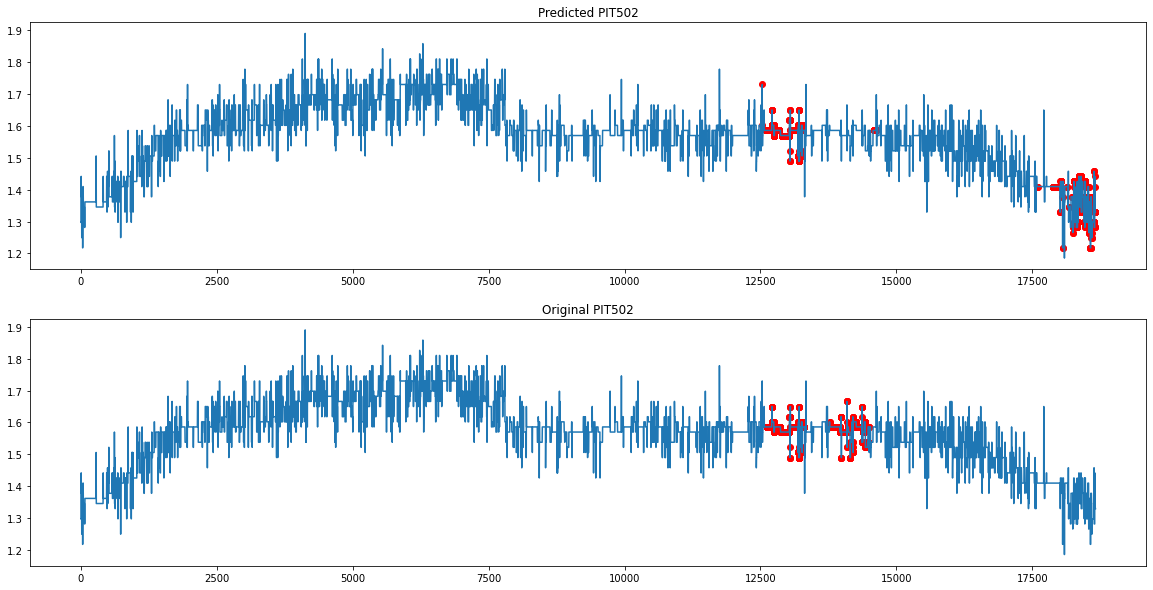

In [90]:
p = "PIT502"

fig, axs = plt.subplots(2, 1, figsize=(20,10))
p_data = df[p]
axs[0].plot(p_data)
axs[1].plot(p_data)

y = pd.Series(prediction, index=df[train_size:].index)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, p_data[anomalies_indecies], color='r')
axs[0].set_title(f"Predicted {p}")

y = pd.Series(anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], p_data[anomalies_indecies], color='r')
axs[1].set_title(f"Original {p}")

plt.show()

In [91]:
f1_score(pd.Series(prediction), anomaly[train_size:])

0.4622390891840607